## Raytracing for Computing the sky view factor
This notebook includes two implementation of SVF computing
1. The CPU based raytracing method to compute the SVF
2. The GPU PyCUDA based method to compute the SVF

This is based on my previous code for the paper published on Landscape and Urban Planning in 2017 at MIT and UCONN. Still using CPU

Last modified and cleaned on Jan 28, 2021 by Xiaojiang Li, Temple University

In [1]:
import os, os.path
import rasterio as rio
from osgeo import gdal
from osgeo.gdalconst import *
from matplotlib import pyplot as plt
import numpy as np
import rasterio
import time
import math


demroot = '/drive2/researchProj/gpu-climate/spatial-data/ground_dsm'

for file in os.listdir(demroot):
    demfile = os.path.join(demroot, file)
    lu_dataset = rio.open(demfile)
    
    lu_bounds = lu_dataset.bounds
    lu_img = lu_dataset.read(1)
    print('The lu_bounds is:', lu_bounds)
    break
    

The lu_bounds is: BoundingBox(left=2698148.0, bottom=233974.0, right=2700788.0, top=236614.0)


In [10]:

# root = '../../data/Philadelphia'
# demfile = os.path.join(root, 'clipedDEM.tif')
# dsmfile = os.path.join(root, 'clipedDSM.tif')
demfile = r'/drive2/researchProj/gpu-climate/spatial-data/26928E223414N_dsm.tif'
demfile = '/drive2/researchProj/gpu-climate/spatial-data/clip_dsm2.tif'
demfile = '/drive2/researchProj/gpu-climate/spatial-data/clip_phily.tif'
demfile = '/drive2/researchProj/gpu-climate/spatial-data/ground_dsm/26981E233974N.tif'

dsmfile = demfile


with rasterio.open(dsmfile) as dsmlayer:
    dsmimg = dsmlayer.read(1)

gdal_dsm = gdal.Open(dsmfile)
dsm = gdal_dsm.ReadAsArray().astype(np.float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]

gdal_dem = gdal.Open(demfile) #dem
dem = gdal_dem.ReadAsArray().astype(np.float)


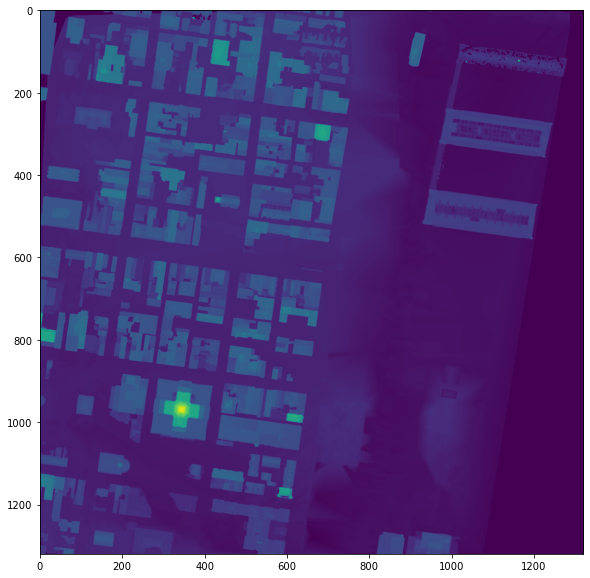

In [11]:

plt.figure(figsize=(10, 10))
plt.imshow(dem)
# plt.show()
plt.savefig('dem.png', dpi=300)


In [15]:

# def GetCentroidValue(fc,rast):
'''
This function is used to overlap the vector file on the raster file
and then compute the number of cols and rows in the raster file
First version July 5, 2016, After PK presentation, MIT Senseable City Lab

Make sure the two files have the same image projection, in this version,
no image transform id conducted, think about in future,

var source = new Proj4js.Proj('PROJ4_ARGS_FOR_YOUR_PROJECTION');
var dest = new Proj4js.Proj('EPSG:4326') // geographic coordinates + WGS84 (which matches the ellipsoid used in your .prj)

parameters:
    fc: the input feature class
    rast: the corresponding raster file
'''

# #open vector layer
# drv=ogr.GetDriverByName('ESRI Shapefile') #assuming shapefile?
# ds=drv.Open(fc,True) #open for editing
# lyr=ds.GetLayer(0)

# # add new field to store the calculated SVF result
# svfDem = ogr.FieldDefn('svfDEM1ft', ogr.OFTReal)
# lyr.CreateField(svfDem)


rast = demfile

#open raster layer
src_ds=gdal.Open(rast) 
gt=src_ds.GetGeoTransform()
rb=src_ds.GetRasterBand(1)
arrayDEM = rb.ReadAsArray()
gdal.UseExceptions() #so it doesn't print to screen everytime point is outside grid

# get the size of the raster
rows = arrayDEM.shape[0]
cols = arrayDEM.shape[1]
print ('The size rows is %s, the cols is %s :', rows,cols)


The size rows is %s, the cols is %s : 1320 1320


### Use raytracing to calculate the SVFfor some pixels

In [14]:
import time
import math


px = 120
py = 400


for px in range(100, 1000, 10):
    try: #in case raster isnt full extent
        structval=rb.ReadRaster(px,py,1,1,buf_type=gdal.GDT_Float32) #Assumes 32 bit int- 'float'
        intval = struct.unpack('f' , structval) #assume float
        val=intval[0]
    except:
        val=-9999 #or some value to indicate a fail
    
    t0 = time.time()
    
    ## CALCULATE SKY VIEW FACTOR FOR ALL GSV SITES
    SVF_res = 0
    
    # search all 360 angles for each pano site
    for thetaN in range(360):
        rangeDist = 200 # 500m
        #rangeFeet = int(rangeDist*3.28084)  # convert the meter to feet
        
        # create points along each angle
        radiusRange = range(5, rangeDist,1)
        theta = np.pi*thetaN/180
        
        # create an empty beta list to store the betas for each spike
        betaLst = []
        
        # create points along the ray line in 200m or 656 feet, one pixel is one foot
        for radius in radiusRange:
            rayX = int(px + radius*math.cos(theta))
            rayY = int(py + radius*math.sin(theta))
            
            # the corresponding building height is, consider the search region could out of the image
            if rayX >= cols or rayX < 0 or rayY >= rows or rayY < 0:
                continue
            
            # because the ground value is not zero, therefore, need to use the relative height
            buildH = arrayDEM[rayY,rayX] - arrayDEM[py, px]
            
            # if the pixel has its height lower than 2.5m, do not consider anymore
            #if buildH < 6.5:
            #    continue
            
            # considering the GSV pano is captured at height of 2.5m
            #beta = math.atan((buildH - 2.5)*3.28084/radius)
            beta = math.atan(buildH/radius)
            betaLst.append(beta)
        
        if len(betaLst)>0:
            maxBeta = max(betaLst)
        else:
            maxBeta = 0
        SVF_res = SVF_res + math.cos(maxBeta)**2
        
    SVF = SVF_res*1.0/360
    
    print('The svf and the time need is:', SVF, time.time() - t0)
    

The svf and the time need is: 0.4267150469829497 0.3681201934814453
The svf and the time need is: 0.5497053312351047 0.37526655197143555
The svf and the time need is: 0.5897536562440686 0.3800795078277588
The svf and the time need is: 0.5470630221852555 0.38437914848327637
The svf and the time need is: 0.4427825305714665 0.39584827423095703
The svf and the time need is: 0.9562095525314924 0.3958775997161865
The svf and the time need is: 0.6116124331207622 0.40204405784606934
The svf and the time need is: 0.5929865758083149 0.40487074851989746
The svf and the time need is: 0.4561960638578115 0.4086740016937256
The svf and the time need is: 0.6493849379461716 0.41056370735168457
The svf and the time need is: 0.7090216698549126 0.411806583404541
The svf and the time need is: 0.7488812847168645 0.41276097297668457
The svf and the time need is: 0.2668776707348777 0.4130687713623047
The svf and the time need is: 0.27039718427677667 0.4109365940093994
The svf and the time need is: 0.244942797

### Using PyCUDA to accelerate the SVF calculation

In [2]:
from pycuda.compiler import SourceModule
import pycuda
from pycuda import gpuarray
from pycuda import compiler
import pycuda.driver as cuda
import pycuda.autoinit             # PyCuda autoinit
import pycuda.driver as cuda       # PyCuda In, Out helpers
import matplotlib.pyplot as plot   # Library to plot
import matplotlib.cm as colormap   # Library to plot
import numpy                       # Fast math library
import time
import numpy as np                     # numeric python lib
import matplotlib.image as mpimg       # reading images to numpy arrays
import matplotlib.pyplot as plt        # to plot any graph
import matplotlib.patches as mpatches  # to draw a circle at the mean contour
import scipy.ndimage as ndi            # to determine shape centrality
# matplotlib setup
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8)      # setting default size of plots


print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print ("Device #%d: %s" % (ordinal, dev.name()))
print (cuda)

1 device(s) found.
Device #0: GeForce GTX 1060 6GB
<module 'pycuda.driver' from '/home/jiang/anaconda3/envs/climategpu/lib/python3.7/site-packages/pycuda/driver.py'>


In [3]:
 #Kernel text
kernel = """

#include <math.h>

#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )
#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )
#define PI 3.1415926


//https://github.com/AlainPaillou/PyCuda_Denoise_Filters/blob/master/PyCuda_KNN_Denoise_Mono.py
__global__ void svfcalculator(float * lattice_out, float * lattice, float scale) //int w, int h
{
    #define NLM_BLOCK_RADIUS    3
    
    int rangeDist = 200;
    
    int imageW = 2000;
    int imageH = 2000;
    
    const long int   ix = blockDim.x * blockIdx.x + threadIdx.x;
    const long int   iy = blockDim.y * blockIdx.y + threadIdx.y;
    const float  x = (float)ix  + 1.0f;
    const float  y = (float)iy  + 1.0f;
    const float limxmin = -1;      //NLM_BLOCK_RADIUS + 2;
    const float limxmax = imageW; // - NLM_BLOCK_RADIUS - 2;
    const float limymin = -1;      //NLM_BLOCK_RADIUS + 2;
    const float limymax = imageH; // - NLM_BLOCK_RADIUS - 2;
    
    long int index4;    
    
    
    if(ix>limxmin && ix<limxmax && iy>limymin && iy<limymax){
        // sky view factor
        float SVF_res = 0;
        
        //Result accumulator
        float clr00 = 0.0;
        float clrIJ = 0.0;
        
        //Center of the KNN window
        index4 = x + (y * imageW);
        
        // the current pixel
        clr00 = lattice[index4];
        
        for(int thetaN =0; thetaN<360; thetaN++) 
        {
            float theta = PI*float(thetaN)/180;
            float betaMax = 0;
            
            for( float radius = 5; radius < rangeDist; radius = radius + 5)
            {   
                // this is important or you will have memory error
                if (x + int(radius*cos(theta)) > limxmax | x + int(radius*cos(theta)) < limxmin | y - int(radius*sin(theta)) > limymax | y - int(radius*sin(theta)) < 0) 
                {
                    break;
                }
            
                long int index2 = x + int(radius*cos(theta)) + (y - int(radius*sin(theta))) * imageW;
                clrIJ = lattice[index2];
                
                // building height information
                float buildH = clrIJ - clr00;
                
                float beta = atan(scale*buildH/radius); //because the pixel resolution is 2ft, height is in ft
                if (betaMax < beta)
                {
                    betaMax = beta;
                }
            }
            SVF_res += pow(cos(betaMax), 2);
        }
        
        lattice_out[index4] = SVF_res/360.0;
    }
    
}
"""


#Compile and get kernel function
mod = SourceModule(kernel)
print (mod)


In [4]:
import PIL
from PIL import Image as PILImage
import rasterio as rio
import numpy
import pycuda.driver as drv


def svfCalculator_RayTracingOnGPU(dsm, scale):
    '''This code is used to calculate the sky view factor using the ray-tracing
    algorithm based on the GPU acceleration
    last modified Jan 27, 2021
    by Xiaojiang Li, Temple University
    
    Parameters:
        dsm: the numpy array of the digital surface model
        scale: is the scale of the image, read from the gdal,
                1px of 2 feet, scale is 0.5; 1px of 3 feet, scale is 0.3333
    '''
    
    px = numpy.array(dsm).astype(numpy.float32)
    
    #print ('Size:' + str(dsm.shape))
    #print ('Pixels:' + str (dsm.shape[0]*dsm.shape[1]))
    #print('The px.nbtyle is:', px.nbytes, px.shape)
    
    
    # allocate memory on the device and transfer data to GPU 
    d_px = cuda.mem_alloc(px.nbytes)
    cuda.memcpy_htod(d_px, px)
    
    height,width = px.shape
    nb_pixels = height * width
    
    # Set blocks et Grid sizes
    nb_ThreadsX = 8
    nb_ThreadsY = 8
    nb_blocksX = (width // nb_ThreadsX) + 1
    nb_blocksY = (height // nb_ThreadsY) + 1

    #print("Test GPU ",nb_blocksX*nb_blocksY," Blocks ",nb_ThreadsX*nb_ThreadsY," Threads/Block")
    tps1 = time.time()
    
    
    # create empty array
    lattice_gpu = gpuarray.to_gpu(px)
    newLattice_gpu = gpuarray.empty_like(lattice_gpu)
    
    # the GPU function
    KNN_Mono_GPU = mod.get_function("svfcalculator")
    KNN_Mono_GPU(newLattice_gpu, d_px, np.float32(scale), \
               block=(nb_ThreadsX,nb_ThreadsY,1), \
               grid=(nb_blocksX,nb_blocksY))  
    
    bwPx = numpy.empty_like(px)    
    bwPx = newLattice_gpu.get()
    
    bwPx = numpy.float32(bwPx)
    #pil_im = PILImage.fromarray(bwPx)
    
    return bwPx
    

### Save the numpy as a geotiff

In [5]:
def saverasternd(gdal_data, filename, raster):
    rows = gdal_data.RasterYSize
    cols = gdal_data.RasterXSize
    
    outDs = gdal.GetDriverByName("GTiff").Create(filename, cols, rows, int(1), GDT_Float32)
    outBand = outDs.GetRasterBand(1)
    
    # write the data
    outBand.WriteArray(raster, 0, 0)
    # flush data to disk, set the NoData value and calculate stats
    outBand.FlushCache()
    outBand.SetNoDataValue(-9999)
    
    # georeference the image and set the projection
    outDs.SetGeoTransform(gdal_data.GetGeoTransform())
    outDs.SetProjection(gdal_data.GetProjection())
    

### Compute SVFs and save the results

In [6]:
import os, os.path
import gdal
from osgeo.gdalconst import *
import time

root = r'/drive2/thermal-env/data/miami/ground_dsm'
outroot = r'/drive2/thermal-env/data/miami/svf'
if not os.path.exists(outroot):
    os.mkdir(outroot)


for file in os.listdir(root):
    filename = os.path.join(root, file)
    t0 = time.time()
    
    ### using rasterio to read the raster dsm
    #dsm_dataset = rio.open(filename)
    #dsm_img = dsm_dataset.read(1)
    
    ### using gdal to read the raster dsm
    gdal_dsm = gdal.Open(filename)
    dsm_img = gdal_dsm.ReadAsArray().astype(np.float)#dsm
    geotransform = gdal_dsm.GetGeoTransform()
    scale = 1 / geotransform[1]
    
    ## calculate the svf
    svfres = svfCalculator_RayTracingOnGPU(dsm_img, scale)
    print('The time and file are:', time.time() - t0, filename)
    
    outsvfname = os.path.join(outroot, 'svf_' + file)
    saverasternd(gdal_dsm, outsvfname, np.asarray(svfres))
    

The time and file are: 3.802354574203491 /drive2/thermal-env/data/miami/ground_dsm/row5-col7.tif
The time and file are: 3.4475760459899902 /drive2/thermal-env/data/miami/ground_dsm/row1-col6.tif
The time and file are: 3.5248067378997803 /drive2/thermal-env/data/miami/ground_dsm/row1-col7.tif
The time and file are: 4.1054487228393555 /drive2/thermal-env/data/miami/ground_dsm/row1-col8.tif
The time and file are: 3.4862232208251953 /drive2/thermal-env/data/miami/ground_dsm/row2-col4.tif
The time and file are: 3.4590840339660645 /drive2/thermal-env/data/miami/ground_dsm/row2-col5.tif
The time and file are: 3.4673335552215576 /drive2/thermal-env/data/miami/ground_dsm/row2-col6.tif
The time and file are: 3.515775442123413 /drive2/thermal-env/data/miami/ground_dsm/row2-col7.tif
The time and file are: 3.4630892276763916 /drive2/thermal-env/data/miami/ground_dsm/row3-col3.tif
The time and file are: 3.4762158393859863 /drive2/thermal-env/data/miami/ground_dsm/row3-col4.tif
The time and file are:

In [7]:
import time

# demfile = r'/drive2/researchProj/gpu-climate/spatial-data/ground_dsm/26981E233974N.tif'
# demfile = r'/drive2/researchProj/gpu-climate/spatial-data/26928E223414N_dsm.tif'
demfile = r'/drive2/thermal-env/data/miami/ground_dsm/row5-col7.tif'

t1 = time.time()

dem_dataset = rio.open(demfile)
dsm_img = dem_dataset.read(1)


res = svfCalculator_RayTracingOnGPU(dsm_img, np.float32(scale))
t2 = time.time()
print('The time elapsed is:', t2-t1)


The time elapsed is: 3.8653388023376465


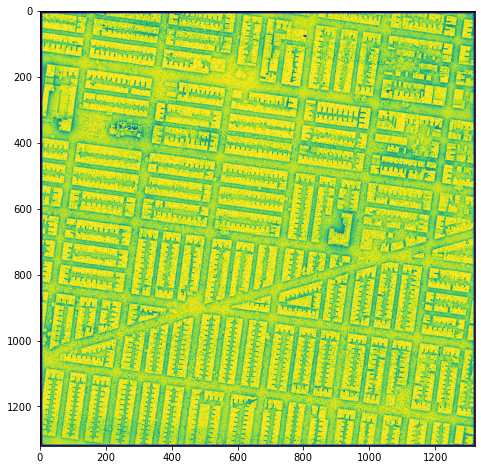

In [19]:
# saverasternd(gdal_dsm, 'svfNfile-dem-gpu.tif', np.asarray(res))

# stopTimer()
plt.imshow(np.asarray(res))
saverasternd(gdal_dsm, 'outsvfname.tif', np.asarray(res))
plt.savefig('svf.png', dpi=300)

In [18]:
import gdal
from osgeo.gdalconst import *

gdal_dsm = gdal.Open(demfile)
dsm = gdal_dsm.ReadAsArray().astype(np.float)#dsm
geotransform = gdal_dsm.GetGeoTransform()
scale = 1 / geotransform[1]
